In [1]:
import torch
from matplotlib import pyplot as plt

def toy_data(dataset_size: int = 4000):
    x = torch.rand(dataset_size, 2) - 0.5
    y = torch.sqrt(x[:, 0] **2 + x[:, 1] ** 2) < 0.4
    return x, y.type(torch.float32).reshape(dataset_size, 1)
    
x, y = toy_data(dataset_size=10000)

print(torch.bincount(y.type(torch.int32).ravel()))


tensor([4955, 5045])


In [2]:
from torch import nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.nn.init import xavier_uniform_


def linear(n, m, init_weight=xavier_uniform_, init_bias=lambda t: t.fill_(0.0)):
    layer = nn.Linear(n, m)
    init_weight(layer.weight)
    init_bias(layer.bias.data)
    return layer


class Perceptron(nn.Module):
    
    def __init__(self, input_dim: int):
        super().__init__()        
        self.fc1 = linear(input_dim, 32)
        self.fc2 = linear(32, 64)
        self.fc3 = linear(64, 1)
    
    
    def forward(self, x_in):
        x = F.relu(self.fc1(x_in))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x


In [3]:
from torch.utils.data import DataLoader, TensorDataset, random_split


if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
    
print(f"Device: {device}")

perceptron = Perceptron(input_dim=2)
perceptron.to(device)
loss_func = nn.BCELoss()
optimizer = Adam(params=perceptron.parameters(), lr=0.001)


n_train = int(x.shape[0] * 0.7)
n_valid = x.shape[0] - n_train

train_set, valid_set = random_split( TensorDataset(x.to(device), y.to(device)), lengths=[n_train, n_valid])
x_valid, y_valid = next(iter(DataLoader(valid_set, batch_size=n_valid)))
batches = DataLoader(train_set, batch_size=512)

history = []
minibatch = 0


x_valid = x_valid.to(device)
y_valid = y_valid.to(device)

from time import time

start_time = time()

for epoch in range(200):
    for i, (batch_x, batch_y) in enumerate(batches):
        start = time()
        
        perceptron.zero_grad()
        
        y_pred = perceptron(batch_x)
        loss = nn.BCELoss()(y_pred, batch_y)
        
        loss.backward()
        optimizer.step()
        
        y_valid_pred = perceptron(x_valid)
        validation_loss = nn.BCELoss()(y_valid_pred, y_valid)
        
        end = time()
        history.append({"epoch": epoch, "loss": loss.item(), "minibatch": minibatch, "validation_loss": validation_loss.item(), "time": end-start})
        minibatch += 1
        
    
    print(history[-1])
end_time = time()

print(f"Training completed in {end_time-start_time} seconds.")

Device: cuda
{'epoch': 0, 'loss': 0.6774353384971619, 'minibatch': 13, 'validation_loss': 0.6766663193702698, 'time': 0.0014884471893310547}
{'epoch': 1, 'loss': 0.6592730283737183, 'minibatch': 27, 'validation_loss': 0.6581240296363831, 'time': 0.001779794692993164}
{'epoch': 2, 'loss': 0.6383735537528992, 'minibatch': 41, 'validation_loss': 0.6360722780227661, 'time': 0.0018482208251953125}
{'epoch': 3, 'loss': 0.6110502481460571, 'minibatch': 55, 'validation_loss': 0.6080516576766968, 'time': 0.0016832351684570312}
{'epoch': 4, 'loss': 0.5767422914505005, 'minibatch': 69, 'validation_loss': 0.574289858341217, 'time': 0.0016412734985351562}
{'epoch': 5, 'loss': 0.5368428826332092, 'minibatch': 83, 'validation_loss': 0.5346333980560303, 'time': 0.0014259815216064453}
{'epoch': 6, 'loss': 0.4925321638584137, 'minibatch': 97, 'validation_loss': 0.49013322591781616, 'time': 0.0020055770874023438}
{'epoch': 7, 'loss': 0.44470158219337463, 'minibatch': 111, 'validation_loss': 0.44263511896

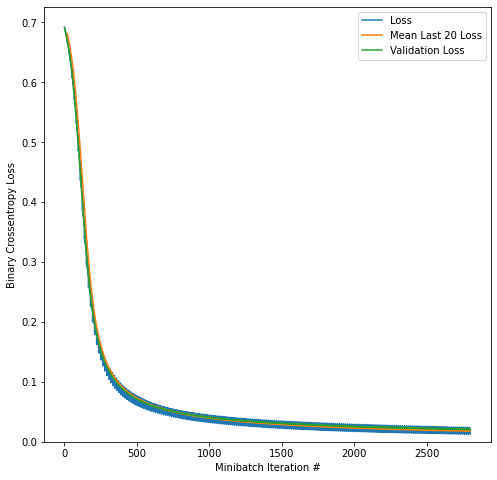

In [4]:
minis, losses = zip(*[(h["minibatch"], h["loss"]) for h in history])
from statistics import mean

window_size = 20
rolling_mean = [mean(losses[i-window_size:i]) for i in range(window_size, len(losses))]
plt.figure(figsize=(8, 8))
plt.plot(minis, losses, label="Loss")
plt.plot(minis[window_size:], rolling_mean, label=f"Mean Last {window_size} Loss")
plt.plot(minis, [h["validation_loss"] for h in history], label="Validation Loss")
plt.xlabel("Minibatch Iteration #")
plt.ylabel("Binary Crossentropy Loss")
plt.ylim(0.0)
plt.legend()

Text(0.5, 1.0, 'Predicted')

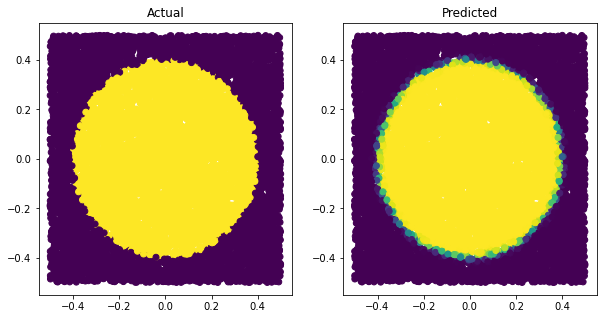

In [5]:
y_pred = perceptron(x.to(device)) #> 0.5
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
ax1.scatter(x[:, 0], x[:, 1], c=y)
ax1.set_title("Actual")
ax2.scatter(x[:, 0], x[:, 1], c=y_pred.to("cpu").detach().numpy())
ax2.set_title("Predicted")